### Embedded deep feature selection

In [1]:
import tensorflow as tf
import numpy as np
import random as rn
seed = 1
rand = np.random.RandomState(seed)
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed) # Setting the graph-level random seed.
import os
os.environ['PYTHONHASHSEED']=str(seed)
import keras
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Layer, Multiply, Reshape, ThresholdedReLU, Dot, \
Activation,LocallyConnected1D,Input, ActivityRegularization, Dropout,  Dense, Lambda
from tensorflow.keras import regularizers, losses
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import clone_model
import pandas as pd
from scipy.io import loadmat
from scipy.io.arff import loadarff 
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import statistics
import pprint
from datetime import datetime
from IPython.display import clear_output
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy

In [2]:
!pip install skrebate
from skrebate import ReliefF
!pip install lassonet==0.0.4 #delete version specification if python 3.8 is avaible 
import lassonet
from lassonet import LassoNetClassifier,  plot_path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '6' 

  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29269 sha256=d1d19321426e74c11b8f6198c9c2b0cf21a83aaea50ef051463594c53cc5e075
  Stored in directory: /root/.cache/pip/wheels/4f/3b/07/22a9a01f3f25cd376122b5ef526737a44993b4c312e50916ed
Successfully built skrebate


### Classes

In [3]:
from tensorflow.keras.constraints import MinMaxNorm
class PairLayer(tf.keras.layers.Layer):

    def __init__(self, activation='sigmoid', cancelout_loss=True, lambda_1=0.002, lambda_2=0.001, lambda_3 = 0.0, init=None):
        super(PairLayer, self).__init__()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3
        self.cancelout_loss = cancelout_loss
        
        if activation == 'sigmoid': self.activation = tf.sigmoid
        elif activation == 'softmax': self.activation = tf.nn.softmax
        else: self.activation = None
        if init == 'glorout' : self.init = tf.keras.initializers.GlorotNormal()
        else: self.init =  tf.keras.initializers.Constant(1)


    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.init,
            trainable=True)#,
            #constraint=MinMaxNorm(min_value = 0, max_value = 1, rate = 1, axis = 0))
        
    def call(self, inputs):
        if self.cancelout_loss:
            shap = self.w.shape[0]
            self.add_loss( self.lambda_1 * tf.norm(self.w, ord=1)  + self.lambda_2 * tf.norm(self.w, ord=2))
            if self.lambda_3 != 0.0:
                self.add_loss(-self.lambda_3 * tf.math.reduce_variance(self.w*(1/shap)))

        if self.activation == None: return inputs * self.w
        else: return inputs * self.activation(self.w)
    
    def get_config(self):
        return {"activation": self.activation} 

In [4]:
class PairwiseFS(Model):
    def __init__(self, inputs, base_model, l1, l2=0.001, l3=0.0, activationCancel='sigmoid', initializer=None):
        self.l1 = l1
        self.inputDim = inputs.shape[1]
        self.activationCancel = activationCancel
        dense = [] 
        inputLayer = Input(shape=(self.inputDim,))

        ##Construct pairwise
        cancel = PairLayer(activation=activationCancel, lambda_1=l1, lambda_2=l2, lambda_3=l3, init=initializer) (inputLayer)
        second = clone_model(base_model) 
        super().__init__(inputs=inputLayer, outputs=second (cancel))


    def get_support(self):
        if self.activationCancel == 'sigmoid':
          weights = tf.sigmoid(self.get_weights()[0])
        else:
          weights = self.get_weights()[0]
        return weights

In [5]:
class NFSLayer(tf.keras.layers.Layer):
    def __init__(self, activation='sigmoid'):
        super(NFSLayer, self).__init__()
        
    def call(self, inputs):
        return inputs[1] * inputs[0]


In [6]:
class NeuralFS(Model):

    def __init__(self, inputs, base_model,l2, dense, l1=0.0, threshold=0.05):
        self.l2 = l2
        self.l1 = l1
        self.inputDim = inputs.shape[1]
        self.inputTensor = inputs
        self.denseHidden = dense
        self.threshold = threshold
        inputLayer = Input(shape=(self.inputDim,))
        dense1 = Dense(self.denseHidden, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2))(inputLayer)
        dense2 = Dense(self.inputDim, activation=self.tr, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2))(dense1) #TL
        pairwise =NFSLayer()([inputLayer, dense2])
        second = clone_model(base_model) 
        ret = second (pairwise)
        super().__init__(inputs=inputLayer, outputs=second (pairwise))

    @tf.function
    def tr(self,x):
        theta = K.cast(self.threshold, K.floatx())
        a = K.cast(K.less(x,-theta) , K.floatx())
        b = K.cast(K.greater(x,theta), K.floatx())
        d = 1 -((1-a)*(1-b)) #A or B
        return x * d


    def get_support(self):
        inputLayer = Input(shape=(self.inputDim,))
        dense1 = Dense(self.denseHidden, activation="relu", \
            weights=[self.get_weights()[0], self.get_weights()[1]])(inputLayer)
        dense2 = Dense(self.inputDim, activation=self.tr, \
                    weights=[self.get_weights()[2], self.get_weights()[3]])(dense1) #TL
        support = Model(inputs=inputLayer, outputs=dense2)
        support.compile(optimizer='adam',
                    loss=losses.CategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
        prediction = support.predict(self.inputTensor)
        supportList = np.mean(prediction, axis=0)
        return supportList

In [9]:
def activation_potential_analysis(X, weights):
    weights_first = weights[0]
    bias = weights[1]
    support = []
    p_ij = np.zeros((X.shape[1], len(weights_first[0])))
    for dim in range(len(weights_first)):
        for hidden in range(len(weights_first[0])):
            for trains in range(X.shape[0]):
                p_ij[dim][hidden] += abs(weights_first[dim][hidden]*X[trains][dim])
            p_ij[dim][hidden] = p_ij[dim][hidden]/X.shape[0] 
            
    sum_j = np.sum(p_ij, axis=1)
    return sum_j

### Generate dataset

In [7]:
def generateGDataset(ndata, nlab, col=""):
    dataset = pd.read_csv(ndata, index_col=0)
    y = pd.read_csv(nlab, index_col=0)
    y = y["x"].replace(-1, 0)
    print(y)
    df = dataset
    if col != "":
        df.columns = col
    print(df)
    dataset = np.asarray(dataset).astype('float32')
    y = np.asarray(y).astype('float32')

    y =  to_categorical(y)
    return dataset, y, df


In [8]:
dataset, y, df = generateGDataset("synth-data.csv","synth-labels.csv" ); dfstr="synth"
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(dataset, y, test_size=0.33, shuffle=False, random_state=1)
dataset, y, df = generateGDataset("gastro-data.csv","gastro-labels.csv" ); dfstr="gastro"
X_train_gastro, X_test_gastro, y_train_gastro, y_test_gastro = train_test_split(dataset, y, test_size=0.33, shuffle=False, random_state=1)
dataset, y, df = generateGDataset("arcene-data.csv","arcene-labels.csv" ); dfstr="arcene"
X_train_arcene, X_test_arcene, y_train_arcene, y_test_arcene = train_test_split(dataset, y, test_size=0.33, shuffle=False, random_state=1)
dataset, y, df = generateGDataset("breast-data.csv","breast-labels.csv" ); dfstr="breast"
X_train_breast, X_test_breast, y_train_breast, y_test_breast = train_test_split(dataset, y, test_size=0.33, shuffle=False, random_state=1)


0       0
1       1
2       0
3       0
4       0
       ..
4995    1
4996    0
4997    1
4998    1
4999    0
Name: x, Length: 5000, dtype: int64
             0         1         2  ...        11        12        13
0     0.974438  0.512138  0.715295  ...  0.519670  0.712883  0.869745
1     0.565240  0.010234  0.972033  ...  0.002810  0.963683  0.427714
2     0.538846  0.944732  0.969621  ...  0.938753  0.971375  0.255436
3     0.538871  0.971940  0.942768  ...  0.971441  0.948124  0.187866
4     0.288532  0.783674  0.153898  ...  0.794125  0.146585  0.725685
...        ...       ...       ...  ...       ...       ...       ...
4995  0.117533  0.565023  0.699624  ...  0.583519  0.706882  0.633915
4996  0.807687  0.867163  0.706474  ...  0.878035  0.702215  0.336603
4997  0.020929  0.128088  0.979723  ...  0.132311  0.962284  0.480559
4998  0.694481  0.262472  0.531470  ...  0.250886  0.531593  0.069454
4999  0.846758  0.884634  0.713214  ...  0.887993  0.714862  0.602781

[5000 rows x 

### Utils

In [10]:
def crossValScore(modelKey,k,X_train,y_train, mapModel, param, epc, bs, verb):
    n_splits = k
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    loss = []
    acc = []
    val_loss = []
    val_acc = []
    final_acc = []
    for train_index, val_index in kf.split(X_train):
        X_train_scal = MinMaxScaler().fit_transform(X_train)
        model = mapModel[modelKey](X_train_scal[train_index],y_train[train_index],param)
        model.compile(optimizer='adam',
                      loss=losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        hist = model.fit(X_train_scal[train_index], y_train[train_index],
                         epochs=epc,
                         batch_size=bs,
                         validation_data = (X_train_scal[val_index], y_train[val_index]),
                         verbose=verb)

        loss.append(hist.history['loss'])
        acc.append(hist.history['accuracy'])
        val_loss.append([hist.history['val_loss']])
        val_acc.append(hist.history['val_accuracy'])
        final_acc.append(hist.history['accuracy'][-1])
        score = np.mean(final_acc)
    return score, acc, loss, final_acc
#print(val_acc)

In [11]:
def filterImportance(X_train,y_train):
    yb = y_train[:,1]
    fsMut = SelectKBest(score_func=mutual_info_classif, k='all')
    fsMut.fit(X_train, yb)
    fsR = ReliefF(n_neighbors=1, n_features_to_select=X_train.shape[1])
    X_train = fsR.fit_transform(X_train, yb)
    fsMSc = fsMut.scores_*(1/(np.amax(fsMut.scores_)))
    fsRSc = fsR.feature_importances_*(1/(np.amax(fsR.feature_importances_)))
    fsUnion = fsMSc + fsRSc
    return fsUnion

In [12]:
def showFeatures(key,w, X_train, params, show=True, score=0):
    w = np.absolute(w)
    #print(w)    
    if X_train.shape[1]<200:
        if key == "pairwise":
          key = key + "; L1=" + str(params["l1_pairwise"]) + "; L2=" + str(params["l2_pairwise"]) + "; L3=" + str(params["l3_pairwise"])
        if key == "cancelOut":
          key = key + "; L1=" + str(params["l1_cancelOut"]) + "; L2=" + str(params["l2_cancelOut"]) + "; L3=" + str(params["l3_cancelOut"])
        if key == "neuralFS":
          key = key + "; Threshold="+ str(params["threshold_neuralfs"]) + "; L2="+ str(params["l2_neuralfs"])
        if key == "regularized":
          key = key + "; Regularized="+ str(params["l1_regularized"])
        fig = plt.figure(figsize=(5, 5))
        fig.suptitle(key, fontsize=16)
        ax = fig.add_axes([0,0,1,1])
        if X_train.shape[1]>200:
            print("too much dimension to display")
        elif X_train.shape[1]>20:
            ax.barh([i for i in range( X_train.shape[1])],[abs(i) for i in w])
            alpha = 0.001
            dy = (max(w) - min(w))
            ax.set_xlim(min(w), max(w)+dy)
            if show:
              plt.show()
            else:
              fig.text(0,1,str(score)[:5],style='italic', bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 6})
        else:
            ax.bar([i for i in range( X_train.shape[1])],[abs(i) for i in w])
            alpha = 0.001
            dy = (max(w) - min(w))
            ax.set_ylim(min(w), max(w)+dy)
            if show:
              plt.show()
            else:
              fig.text(0,1,str(score)[:5],style='italic', bbox={'facecolor': 'grey', 'alpha': 0.2, 'pad': 6})


    return fig

In [13]:
def computeSupport(w, n):
    w = np.absolute(w)
    sortedFeat = sorted(w)
    thres = sortedFeat[-n]
    support = []
    #print(w)
    for i in w:
        if i < thres or i <= 0.0:
            support.append(False)
        else:
            support.append(True)
    pres = support.count(True)
    if pres < n:
        count = 0
        ind = 0
        while count < n-pres:
            if support[ind] == False:
                count += 1
                support[ind] = True
            ind += 1
    return support



In [14]:
def computeSupportPercent(w, p):
    w = np.absolute(w)
    sortedFeat = sorted(w)
    sortedFeat.reverse()
    sumFeat = np.sum(w)
    thresPerc = sumFeat*(p/100)
    support = []
    thres = 0
    for i in range(len(sortedFeat)):
        thres += sortedFeat[i]
        if thres+(1*(10**(-5))) >= round(thresPerc,7):
            return computeSupport(w,i+1)
    return False

In [15]:
def writeOut(name, params, result, dfstr):
    with open(name, "a") as file:
        file.write("###")
        file.write("\n")
        file.write(dfstr)
        file.write("\n")
        now = datetime.now()
        timestamp = datetime.timestamp(now)
        file.write(str(now))
        file.write("\n")
        file.write(str(params))
        file.write("\n")
        file.write(str(result))
        file.write("\n")


### Models

In [16]:
def createBaseline(X_train,y_train,params):
    baseline = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(params["dense1_baseline"],activation='relu', kernel_regularizer=regularizers.l1_l2(l1=params["l1_baseline"], l2=params["l2_baseline"]), kernel_initializer='glorot_normal'),
        Dense(params["dense2_baseline"],activation='relu', kernel_regularizer=regularizers.l1_l2(l1=params["l1_baseline"], l2=params["l2_baseline"]),  kernel_initializer='glorot_normal'),
        Dense(params["dense3_baseline"],activation='relu', kernel_regularizer=regularizers.l1_l2(l1=params["l1_baseline"], l2=params["l2_baseline"]),  kernel_initializer='glorot_normal'),
        Dense(y.shape[1], activation='softmax')
    ])
    return baseline




In [17]:
def createRegularized(X_train,y_train,params):
    regularized = Sequential([
    Dense(X_train.shape[1],activation='relu', kernel_regularizer=regularizers.l1(params["l1_regul"]), input_shape=(X_train.shape[1],)),
    clone_model(createBaseline(X_train,y_train,params))
    ])
    return regularized

In [18]:
def createCancelOut(X_train,y_train,params):
    cancelOut =  PairwiseFS(inputs=X_train, base_model=createBaseline(X_train,y_train,params), l1=params["l1_cancelOut"], l2=params["l2_cancelOut"], l3=params["l3_cancelOut"], initializer=params["initialiser_cancelOut"])
    return cancelOut


In [19]:
def createPairwise(X_train,y_train,params):
    pairwise = PairwiseFS(inputs=X_train, base_model=createBaseline(X_train,y_train,params), l1=params["l1_pairwise"], l2=params["l2_pairwise"], l3=params["l3_pairwise"], activationCancel=None, initializer=params["initialiser_pairwise"])
    return pairwise

In [20]:
def createNeuralFS(X_train,y_train, params):
    if params.get("dense_neuralfs")  == None:
      params['dense_neuralfs'] = X_train.shape[1]
    #print(params)
    neuralFS = NeuralFS(inputs=X_train, base_model=createBaseline(X_train,y_train,params), l2=params["l2_neuralfs"], dense=params['dense_neuralfs'], l1=params["l1_neuralfs"],threshold=params["threshold_neuralfs"])
    return neuralFS


In [21]:
def createLassoNet(X_train,y_train,params):
    lassoModel =  LassoNetClassifier(lambda_start=0.1, verbose=1, hidden_dims=(params['dense1_baseline'], params['dense2_baseline'],params['dense1_baseline']))
    return lassoModel

In [22]:
#Run this cell if you change any model
mapModel = {'neuralFS': createNeuralFS, "pairwise" : createPairwise,
           "cancelOut" : createCancelOut, "baseline": createBaseline, "regularized": createRegularized, 'lassonet' : createLassoNet}

In [23]:
def testModels(X_train, y_train, modelList,params,epc, X_test, y_test, percent=False,nFeat=None, showFeat=False, cols=False):
    retMap = {}
    baseline = createBaseline(X_train,y_train,params)
    baseline.compile(optimizer='adam',
    loss=losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    baseline.fit(X_train,y_train,epochs=epc, verbose=0)
    test_loss, test_acc = baseline.evaluate(X_test,  y_test, verbose=1)
    retMap["shape"] = X_train.shape
    retMap["test_acc_baseline"] = test_acc
    y_pred1 = baseline.predict(X_test)
    y_pred = np.argmax(y_pred1, axis=1)
    y_true = np.argmax(y_test, axis=1)
    bcr = balanced_accuracy_score(y_true, y_pred)
    retMap["test_bcr_baseline"] = bcr
    for key in modelList:
        #print("$$__"+key)
        if key == "lassonet":
          model = mapModel[key](X_train,y_train,params)
          path = model.path(X_train,  np.argmin(y_train, axis=1))
          w = model.feature_importances_.tolist()
          #print(w)
          if showFeat:
            showFeatures(key,w, X_train, params)
          retMap["test_bcr_full_"+key] = 0.5
        elif key != "filter":
            #print(mapModel)
            model = mapModel[key](X_train,y_train,params)
            model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            model.fit(X_train,y_train,epochs=epc, verbose=0)
            test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)
            y_pred1 = model.predict(X_test)
            y_pred = np.argmax(y_pred1, axis=1)
            y_true = np.argmax(y_test, axis=1)

            bcr = balanced_accuracy_score(y_true, y_pred)
            if key in ["baseline", "regularized", "dropout"]:
                w = activation_potential_analysis(X_train, model.get_weights())
                w = [abs(number) for number in w]
            else:
                w = model.get_support()
                w = [abs(number) for number in w]
            if showFeat:
                showFeatures(key,w, X_train, params)
            retMap["test_acc_full_"+key] = test_acc
            retMap["test_bcr_full_"+key] = bcr
        else:
            w = filterImportance(X_train, y_train)
            if showFeat:
                showFeatures(key,w, params)
        if nFeat != None:
            if percent == True:
                support = computeSupportPercent(w,nFeat)
            else:
                support = computeSupport(w,nFeat)
            #print(support)
            #print("\n")
            retMap['selFeatures'] = sum(1 for element in support if element == True)
            #print(retMap["selFeatures"])
            X_train_red = X_train[:,support]
            X_test_red = X_test[:,support]
            retMap["shape_reduced_"+key] = X_train_red.shape
            if cols == True:
                retMap["columns_reduced_"+key] = df.columns[support].values.tolist()
            baseline = createBaseline(X_train_red,y_train,params)
            baseline.compile(optimizer='adam',
                loss=losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
            baseline.fit(X_train_red,y_train,epochs=epc, verbose=0)
            test_loss, test_acc = baseline.evaluate(X_test_red,  y_test, verbose=0)
            retMap["test_acc_baseline_reduced_from_"+key] = test_acc
            y_pred1 = baseline.predict(X_test_red)
            y_pred = np.argmax(y_pred1, axis=1)
            y_true = np.argmax(y_test, axis=1)
            bcr = balanced_accuracy_score(y_true, y_pred)
            retMap["test_bcr_baseline_reduced_from_"+key] = bcr
    return retMap




In [24]:
def chooseParam(dfstr):
  if dfstr == 'arcene':
    params={'dense1_baseline': 50, 'dense2_baseline': 100, 'dense3_baseline': 10, 'initialiser_cancelOut': 'glorout', 'initialiser_pairwise': 'glorout', 'k': 3, 'l1_baseline': 0.001, 'l1_cancelOut': 0.5, 'l1_neuralfs': 0.0, 'l1_pairwise': 0.05, 'l1_regul': 0.01, 'l2_baseline': 0.01, 'l2_cancelOut': 0.4, 'l2_neuralfs': 0.1, 'l2_pairwise': 0.0, 'l3_cancelOut': 0.5, 'l3_pairwise': 0.0, 'lassonet_m' : 0.02, 'threshold_neuralfs': 0.1, 'dense_neuralfs' : int(X_train_arcene.shape[1]/3)}
  elif dfstr == 'synth':
    params = {'dense1_baseline': 50, 'dense2_baseline': 100, 'dense3_baseline': 10, 'initialiser_cancelOut': 'glorout', 'initialiser_pairwise': 'const', 'k': 3, 'l1_baseline': 0.001, 'l1_cancelOut': 0.05, 'l1_neuralfs': 0.0, 'l1_pairwise': 0.02, 'l1_regul': 0.01, 'l2_baseline': 0.001, 'l2_cancelOut': 0.25, 'l2_neuralfs': 0.05, 'l2_pairwise': 0.05, 'l3_cancelOut': 1, 'l3_pairwise': 0.1, 'lassonet_m' : 20, 'threshold_neuralfs': 0.005}
  elif dfstr == 'gastro':
    params = {'dense1_baseline': 50, 'dense2_baseline': 50, 'dense3_baseline': 100, 'initialiser_cancelOut': 'const', 'initialiser_pairwise': 'glorout', 'k': 3, 'l1_baseline': 0.001, 'l1_cancelOut': 0.05, 'l1_neuralfs': 0.0, 'l1_pairwise': 0.05, 'l1_regul': 0.01, 'l2_baseline': 0.001, 'l2_cancelOut': 0.0, 'l2_neuralfs': 0.05, 'l2_pairwise': 0.0, 'l3_cancelOut': 0.01, 'l3_pairwise': 0.0, 'lassonet_m' : 10, 'threshold_neuralfs': 0.5}
  elif dfstr == 'breast':
    params={'dense1_baseline': 10, 'dense2_baseline': 50, 'dense3_baseline': 100, 'initialiser_cancelOut': 'const', 'initialiser_pairwise': 'const', 'k': 3, 'l1_baseline': 0.001, 'l1_cancelOut': 0.02, 'l1_neuralfs': 0.0, 'l1_pairwise': 0.02, 'l1_regul': 0.01, 'l2_baseline': 0.001, 'l2_cancelOut': 0.05, 'l2_neuralfs': 0.5, 'l2_pairwise': 0.0, 'l3_cancelOut': 0.01, 'l3_pairwise': 0.0, 'lassonet_m' : 5, 'threshold_neuralfs': 0.005}
  else:
    params = { "l1_baseline" : 0.001, "l2_baseline" : 0.001, "dense1_baseline" : 100, "dense2_baseline" : 100, "dense3_baseline" : 100, "l1_regul" : 0.03, "l1_cancelOut" : 0.6, "l2_cancelOut" : 0.2, "l3_cancelOut": 0, "initialiser_cancelOut" : 'const', "l1_pairwise" : 0.2, "l2_pairwise": 0.0, "l3_pairwise": 0.0, "initialiser_pairwise" : 'glorout', "l1_neuralfs" : 0.00, "l2_neuralfs" : 0.05, 'lassonet_m' : 10, "threshold_neuralfs" : 0.05 }
  return params

In [25]:
#pprint.pprint(params)
X_train_synth_not_scaled = X_train_synth
X_train_breast_not_scaled = X_train_breast
X_train_arcene_not_scaled = X_train_arcene
X_train_gastro_not_scaled = X_train_gastro
X_train_synth = MinMaxScaler().fit_transform(X_train_synth)
X_test_synth = MinMaxScaler().fit_transform(X_test_synth)
X_train_gastro = MinMaxScaler().fit_transform(X_train_gastro)
X_test_gastro = MinMaxScaler().fit_transform(X_test_gastro)
X_train_arcene = MinMaxScaler().fit_transform(X_train_arcene)
X_test_arcene = MinMaxScaler().fit_transform(X_test_arcene)
X_train_breast = MinMaxScaler().fit_transform(X_train_breast)
X_test_breast = MinMaxScaler().fit_transform(X_test_breast)


### Utils others

In [26]:
def crossStab(key,k,X_train,y_train, X_test, y_test, mapModel, params, percent, nFeat, epc, bs, verb):
    #kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    sups = []
    if key == "filter":
      return 1.0
    else:
      for ite in range(k):
          if key == "lassonet":
            model = mapModel[key](X_train,y_train,params)
            path = model.path(X_train,  np.argmin(y_train, axis=1))
            w = model.feature_importances_.tolist()
            #print(w)
          else:
            model = mapModel[key](X_train,y_train,params)
            model.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            model.fit(X_train,y_train,epochs=epc, verbose=0)
            test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)
            if key in ["baseline", "regularized", "dropout"]:
                w = activation_potential_analysis(X_train, model.get_weights())
                w = [abs(number) for number in w]
            else:
                w = model.get_support()
                w = [abs(number) for number in w]
          if percent == True:
              support = computeSupportPercent(w,nFeat)
          else:
              support = computeSupport(w,nFeat)
          sups.append(support)
      dim = len(sups[0])
      if percent == True:
          index = jaccardIndex(sups,k,dim)
          #print("Mean jacc index ",key,": ",index)

      else:
          index = kunchevaIndex(sups,k,dim, nFeat)
          #print("Kuncheva index ", key,": ",index)
    return index

In [27]:
def jaccardIndex(sups, k, dim):
    jacc = 0
    count = 0
    for i in range(k-1):
        for j in range(i+1,k):
            if i != j:
                count += 1
                card = 0
                a = 0
                for l in range(dim):
                    if sups[i][l] == True or sups[j][l] == True:
                        a += 1
                    if sups[i][l] == True and sups[j][l] == True:
                        card += 1
                jacc += (card/(a))
    jacc_index = jacc/count
    return jacc_index

In [28]:
def kunchevaIndex(sups,k, dim, nFeat):
    interKun = 0
    for i in range(k-1):
        for j in range(i+1,k):
            card = 0
            for l in range(dim):
                if sups[i][l] == True and sups[j][l] == True:
                    card += 1
            interKun += (card - ((nFeat**2)/dim)) / (nFeat - ((nFeat**2)/dim)) 
    kun_index =  2*interKun/(k*(k-1))
    return kun_index

In [29]:
def testWithtoutReduce(key, X_train, y_train, X_test, y_test, params, epc):
      if key == "lassonet":
        model = mapModel[key](X_train,y_train,params)
        path = model.path(X_train,  np.argmin(y_train, axis=1))
        w = model.feature_importances_.tolist()
        #print(w)
      else:
        model = mapModel[key](X_train,y_train,params)
        model.compile(optimizer='adam',
        loss=losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
        model.fit(X_train,y_train,epochs=epc, verbose=0)
        test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)
        y_pred1 = model.predict(X_test)
        y_pred = np.argmax(y_pred1, axis=1)
        y_true = np.argmax(y_test, axis=1)
        bcr = balanced_accuracy_score(y_true, y_pred)
        if key in ["baseline", "regularized", "dropout"]:
            w = activation_potential_analysis(X_train, model.get_weights())
            w = [abs(number) for number in w]
        else:
            w = model.get_support()
            w = [abs(number) for number in w]
      showFeatures(key,w, X_train, params, show=False, score=bcr)
      clear_output(wait=False)
      #print("BCR: ",bcr)
      return bcr

In [30]:
def testAllParam3(X_train,y_train,X_test,y_test,X_train_not_scaled,param, params, list_param,key, nFeatures, _epc, param2='.', list_param2=False, param3='.', list_param3=False):
  reduced = []
  full = []
  stab= []
  selFeatures = []
  for i in range(len(list_param)):
    params[param] = list_param[i]
    if list_param2 != False:
      params[param2] = list_param2[i]
    if list_param3 != False:
      params[param3] = list_param3[i]

    res = testModels(X_train, y_train, [key], params, 100, X_test, y_test, percent=True,nFeat=nFeatures, showFeat=False, cols=False)
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
    full.append(res["test_bcr_full_"+key])
    selFeatures.append(res["selFeatures"])
    stability = crossStab(key, 2, X_train, y_train, X_test, y_test, mapModel, params, percent=True,nFeat=nFeatures,epc=_epc,bs=32,verb=0)
    stab.append(stability)
  return full,reduced,selFeatures,stab

In [31]:
from scipy import stats

def confidenceInterval(listBCR, dstr):
  arrBCR = np.array(listBCR)
  if dstr == 'synth':
    n = 1650
  elif dstr == "breast":
    n = 188
  elif dstr == 'gastro':
    n = 26
  elif dstr == 'arcene':
    n = 66
  else:
    print("bad dataset")
  phat = arrBCR*(1-arrBCR)
  arr = 1.96*np.sqrt((phat/n))
  return arr

In [32]:
datasetStr=["synth", "breast", "gastro", "arcene"]
def plotsParams(title):
  label = [str(i) for i in list_param]
  fig = plt.figure()  # create a figure object
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  plt.title(title)
  ax.plot(label, full_synth, color="blue")
  arr =  np.array([0.01 for i in range(len(full_synth))])
  ax.fill_between(label, np.array(full_synth) + confidenceInterval(full_synth, "synth"), np.array(full_synth) - confidenceInterval(full_synth, "synth"), edgecolor="blue", alpha=0.3)
  ax.plot(full_breast, color="orange")
  ax.fill_between(label, np.array(full_breast) + confidenceInterval(full_breast, "breast"), np.array(full_breast) - confidenceInterval(full_breast, "breast"),  edgecolor="orange", alpha=0.3)
  ax.plot(full_gastro, color="green")
  ax.fill_between(label, np.array(full_gastro) + confidenceInterval(full_gastro, "gastro"), np.array(full_gastro) - confidenceInterval(full_gastro, "gastro"), edgecolor="green", alpha=0.3)
  ax.plot(full_arcene, color="red")
  ax.fill_between(label, np.array(full_arcene) + confidenceInterval(full_arcene, "arcene"), np.array(full_arcene) - confidenceInterval(full_arcene, "arcene"),  edgecolor="red", alpha=0.3)
  plt.ylabel('BCR')
  plt.xlabel('parameter')
  plt.legend(datasetStr)

  plt.title(title)
  plt.plot(label, full_synth)
  plt.plot(full_breast)
  plt.plot(full_gastro)
  plt.plot(full_arcene)
  plt.plot(reduced_synth, "b--")
  plt.plot(reduced_breast, "--", color="orange")
  plt.plot(reduced_gastro, "g--")
  plt.plot(reduced_arcene, "r--")
  plt.ylabel('BCR')
  plt.xlabel('parameter')
  plt.legend(datasetStr)

  fig = plt.figure()  # create a figure object
  plt.title(title)
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  ax.plot(label, np.array(selFeatures_synth)*(1/X_train_synth.shape[1]) )
  ax.plot(label, np.array(selFeatures_breast)*(1/X_train_breast.shape[1]) )
  ax.plot(label, np.array(selFeatures_gastro)*(1/X_train_gastro.shape[1]) )
  ax.plot(label, np.array(selFeatures_arcene)*(1/X_train_arcene.shape[1]) )
  plt.ylabel('Ratio of features selected')
  plt.xlabel('parameter')
  ax.legend(datasetStr)

  fig = plt.figure()  # create a figure object
  plt.title(title)
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  list1, list2 = zip(*sorted(zip(np.array(selFeatures_synth)*(1/X_train_synth.shape[1]), full_synth)))
  ax.plot(list1, list2,"-o")
  list1, list2 = zip(*sorted(zip(np.array(selFeatures_breast)*(1/X_train_breast.shape[1]), full_breast)))
  ax.plot(list1, list2,"-o")
  list1, list2 = zip(*sorted(zip(np.array(selFeatures_gastro)*(1/X_train_gastro.shape[1]), full_gastro)))
  ax.plot(list1, list2,"-o")
  list1, list2 = zip(*sorted(zip( np.array(selFeatures_arcene)*(1/X_train_arcene.shape[1]), full_arcene)))
  ax.plot(list1, list2,"-o")
  plt.ylabel('BCR from full')
  plt.xlabel('Ratio of features selected')
  ax.legend(datasetStr)
  #fig = plt.figure()  # create a figure object
  #plt.title(title)
  #ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  list1, list2 = zip(*sorted(zip(np.array(selFeatures_synth)*(1/X_train_synth.shape[1]), reduced_synth)))
  ax.plot(list1, list2, "bo--")
  list1, list2 = zip(*sorted(zip(np.array(selFeatures_breast)*(1/X_train_breast.shape[1]), reduced_breast)))
  ax.plot(list1, list2, "o--", color='orange')
  list1, list2 = zip(*sorted(zip(np.array(selFeatures_gastro)*(1/X_train_gastro.shape[1]), reduced_gastro)))
  ax.plot(list1, list2, "go--")
  list1, list2 = zip(*sorted(zip( np.array(selFeatures_arcene)*(1/X_train_arcene.shape[1]), reduced_arcene)))
  ax.plot(list1, list2, "ro--")
  #plt.ylabel('BCR from reduced')
  #plt.xlabel('Ratio of features selected')
  #ax.legend(['synth', 'breast', 'gastro', "arcene"])

  fig = plt.figure()  # create a figure object
  plt.title(title)
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  sels = [np.mean(np.array(selFeatures_synth)*(1/X_train_synth.shape[1])), np.mean(np.array(selFeatures_breast)*(1/X_train_breast.shape[1])), \
          np.mean(np.array(selFeatures_gastro)*(1/X_train_gastro.shape[1])), np.mean(np.array(selFeatures_arcene)*(1/X_train_arcene.shape[1]))]
  ax.bar(datasetStr, sels)
  plt.ylabel('Mean Ratio of features selected over parameter')

In [33]:

def plotStabBcr(title, dstr):
  fig = plt.figure(figsize=(6, 6))
  symbol = ["o","s", "x","d", "^","P"]
  colors = ["b", "orange", "g", "r", "k", "c","pink"]
  plt.title(title)
  legend = []
  for j in range(len(listStab)):
    for i in range(len(listStab[j])):
      plt.errorbar( listStab[j][i], listBCR[j][i], yerr=confidenceInterval(listBCR[j][i], dstr), marker = symbol[j],\
                   markersize=10.0,  color = colors[i%len(listStab[0])], ecolor="grey")

  for i in range(len(models)):
    legend.append(Line2D([0], [0],marker='o', color=colors[i], lw=0.004, label=models[i]))
  for i in range(len(list_run)):
    legend.append(Line2D([0], [0],marker=symbol[i], color='k', lw=0.004, label=list_run[i]))
  plt.legend(handles=legend)
  plt.ylabel('BCR from reduced')
  plt.xlabel('Stability from reduced')

In [34]:
def plotParamsCancel(title):
  label = [str(i) for i in list_param]
  fig = plt.figure()  # create a figure object
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  plt.title(title)
  ax.plot(label, cancel_full_synth, color="blue")
  arr =  np.array([0.01 for i in range(len(cancel_full_synth))])
  ax.fill_between(label, np.array(cancel_full_synth) + confidenceInterval(cancel_full_synth, "synth"), np.array(cancel_full_synth) - confidenceInterval(cancel_full_synth, "synth"), edgecolor="blue", alpha=0.3)
  ax.plot(cancel_full_breast, color="orange")
  ax.fill_between(label, np.array(cancel_full_breast) + confidenceInterval(cancel_full_breast, "breast"), np.array(cancel_full_breast) - confidenceInterval(cancel_full_breast, "breast"),  edgecolor="orange", alpha=0.3)
  ax.plot(cancel_full_gastro, color="green")
  ax.fill_between(label, np.array(cancel_full_gastro) + confidenceInterval(cancel_full_gastro, "gastro"), np.array(cancel_full_gastro) - confidenceInterval(cancel_full_gastro, "gastro"), edgecolor="green", alpha=0.3)
  ax.plot(cancel_full_arcene, color="red")
  ax.fill_between(label, np.array(cancel_full_arcene) + confidenceInterval(cancel_full_arcene, "arcene"), np.array(cancel_full_arcene) - confidenceInterval(cancel_full_arcene, "arcene"),  edgecolor="red", alpha=0.3)
  plt.ylabel('BCR')
  plt.xlabel('parameter')
  plt.legend(datasetStr)

  plt.title(title)
  plt.plot(label, cancel_full_synth)
  plt.plot(cancel_full_breast)
  plt.plot(cancel_full_gastro)
  plt.plot(cancel_full_arcene)
  plt.plot(cancel_reduced_synth, "b--")
  plt.plot(cancel_reduced_breast, "--", color="orange")
  plt.plot(cancel_reduced_gastro, "g--")
  plt.plot(cancel_reduced_arcene, "r--")
  plt.ylabel('BCR')
  plt.xlabel('parameter')
  plt.legend(datasetStr)

  fig = plt.figure()  # create a figure object
  plt.title(title)
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  ax.plot(label, np.array(cancel_selFeatures_synth)*(1/X_train_synth.shape[1]) )
  ax.plot(label, np.array(cancel_selFeatures_breast)*(1/X_train_breast.shape[1]) )
  ax.plot(label, np.array(cancel_selFeatures_gastro)*(1/X_train_gastro.shape[1]) )
  ax.plot(label, np.array(cancel_selFeatures_arcene)*(1/X_train_arcene.shape[1]) )
  plt.ylabel('Ratio of features selected')
  plt.xlabel('parameter')
  ax.legend(datasetStr)

  fig = plt.figure()  # create a figure object
  plt.title(title)
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  list1, list2 = zip(*sorted(zip(np.array(cancel_selFeatures_synth)*(1/X_train_synth.shape[1]), cancel_full_synth)))
  ax.plot(list1, list2,"-o")
  list1, list2 = zip(*sorted(zip(np.array(cancel_selFeatures_breast)*(1/X_train_breast.shape[1]), cancel_full_breast)))
  ax.plot(list1, list2,"-o")
  list1, list2 = zip(*sorted(zip(np.array(cancel_selFeatures_gastro)*(1/X_train_gastro.shape[1]), cancel_full_gastro)))
  ax.plot(list1, list2,"-o")
  list1, list2 = zip(*sorted(zip( np.array(cancel_selFeatures_arcene)*(1/X_train_arcene.shape[1]), cancel_full_arcene)))
  ax.plot(list1, list2,"-o")
  plt.ylabel('BCR from full')
  plt.xlabel('Ratio of features selected')
  ax.legend(datasetStr)
  #fig = plt.figure()  # create a figure object
  #plt.title(title)
  #ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  list1, list2 = zip(*sorted(zip(np.array(cancel_selFeatures_synth)*(1/X_train_synth.shape[1]), cancel_reduced_synth)))
  ax.plot(list1, list2, "bo--")
  list1, list2 = zip(*sorted(zip(np.array(cancel_selFeatures_breast)*(1/X_train_breast.shape[1]), cancel_reduced_breast)))
  ax.plot(list1, list2, "o--", color='orange')
  list1, list2 = zip(*sorted(zip(np.array(cancel_selFeatures_gastro)*(1/X_train_gastro.shape[1]), cancel_reduced_gastro)))
  ax.plot(list1, list2, "go--")
  list1, list2 = zip(*sorted(zip( np.array(cancel_selFeatures_arcene)*(1/X_train_arcene.shape[1]), cancel_reduced_arcene)))
  ax.plot(list1, list2, "ro--")
  #plt.ylabel('BCR from reduced')
  #plt.xlabel('Ratio of features selected')
  #ax.legend(['synth', 'breast', 'gastro', "arcene"])

  fig = plt.figure()  # create a figure object
  plt.title(title)
  ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
  sels = [np.mean(np.array(cancel_selFeatures_synth)*(1/X_train_synth.shape[1])), np.mean(np.array(cancel_selFeatures_breast)*(1/X_train_breast.shape[1])), \
          np.mean(np.array(cancel_selFeatures_gastro)*(1/X_train_gastro.shape[1])), np.mean(np.array(cancel_selFeatures_arcene)*(1/X_train_arcene.shape[1]))]
  ax.bar(datasetStr, sels)
  plt.ylabel('Mean Ratio of features selected over parameter')

###Test Models

pairwise

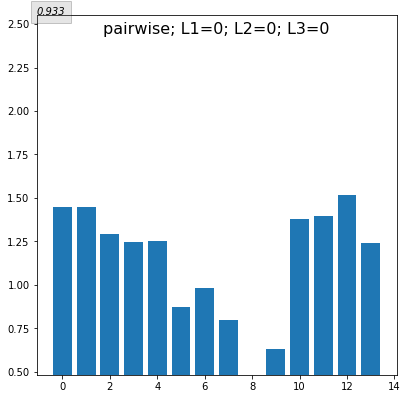

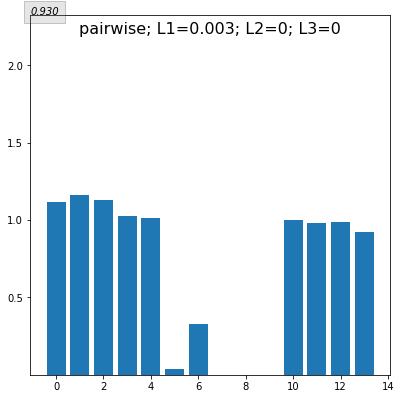

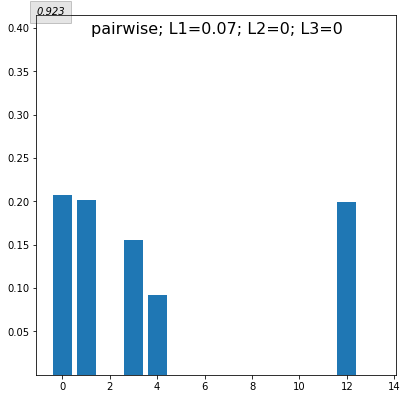

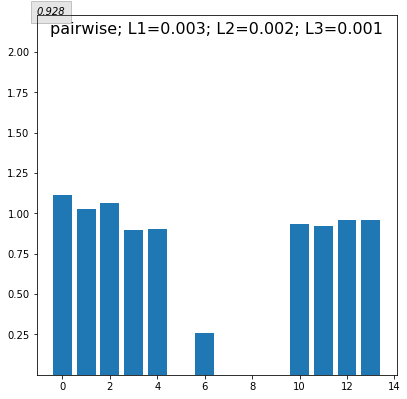

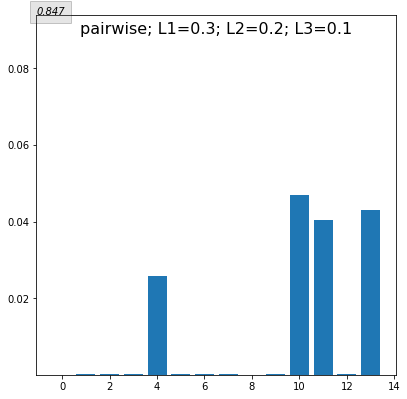

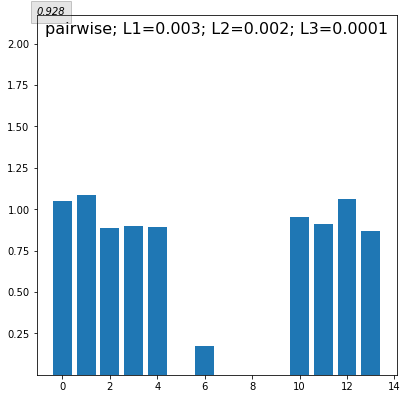

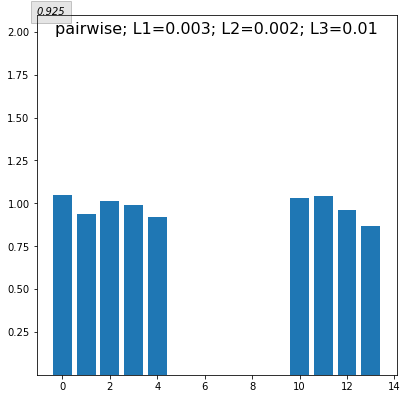

In [ ]:
param1 = [0,0.003,0.07,0.003,0.3, 0.003, 0.003]
param2 = [0,0,0,0.002,0.2,0.002,0.002]
param3 = [0,0,0,0.001, 0.1, 0.0001, 0.01]
for i in range(len(param1)):
  paramTuned = chooseParam("synth")
  paramTuned['l1_pairwise'] = param1[i]
  paramTuned['l2_pairwise'] = param2[i]
  paramTuned['l3_pairwise'] = param3[i]
  key = "pairwise"
  bcr = testWithtoutReduce(key, X_train_synth, y_train_synth, X_test_synth, y_test_synth, paramTuned, 100)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

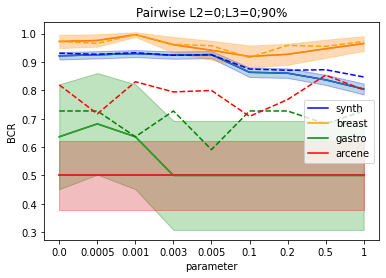

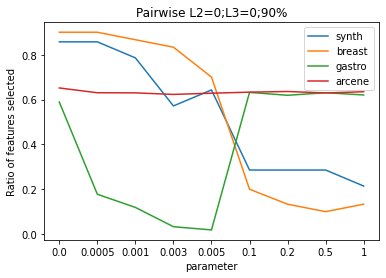

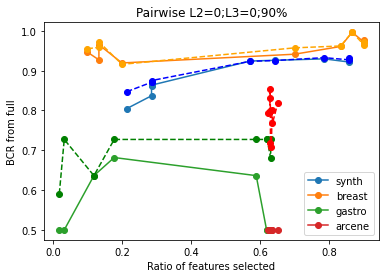

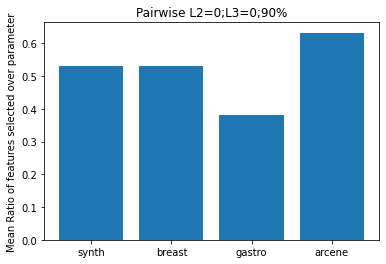

In [ ]:
key = "pairwise"
param = "l1_pairwise"
param2 = "l2_pairwise"
param3 = "l3_pairwise"
list_param =[0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
#list_param =[0.000,0.0005]
list_param2 = [0 for i in list_param] 
list_param3  = [0 for i in list_param] 


full_synth, reduced_synth, selFeatures_synth, stab_synth = \
testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 90, 100, param2, list_param2, param3, list_param3)

full_gastro, reduced_gastro, selFeatures_gastro, stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key,90,100, param2, list_param2, param3, list_param3)

full_arcene, reduced_arcene, selFeatures_arcene, stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key,90,100, param2, list_param2, param3, list_param3)

full_breast, reduced_breast, selFeatures_breast, stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key,90,100, param2, list_param2, param3, list_param3)

clear_output(wait=True)
plotsParams("Pairwise L2=0;L3=0;90%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

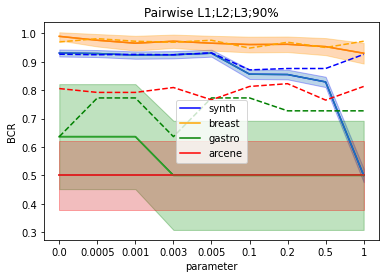

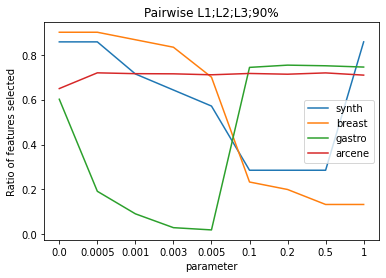

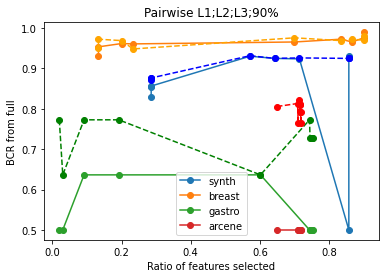

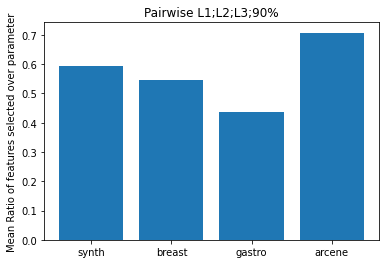

In [ ]:
key = "pairwise"
param = "l1_pairwise"
param2 = "l2_pairwise"
param3 = "l3_pairwise"
list_param = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
list_param2 = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
list_param3  = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
full_synth, reduced_synth, selFeatures_synth, stab_synth = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 90, 100, param2, list_param2, param3, list_param3)

full_gastro, reduced_gastro, selFeatures_gastro, stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key,90,100, param2, list_param2, param3, list_param3)

full_arcene, reduced_arcene, selFeatures_arcene, stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key,90,100, param2, list_param2, param3, list_param3)

full_breast, reduced_breast, selFeatures_breast, stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key,90,100, param2, list_param2, param3, list_param3)

clear_output(wait=True)
plotsParams("Pairwise L1;L2;L3;90%")

CancelOut


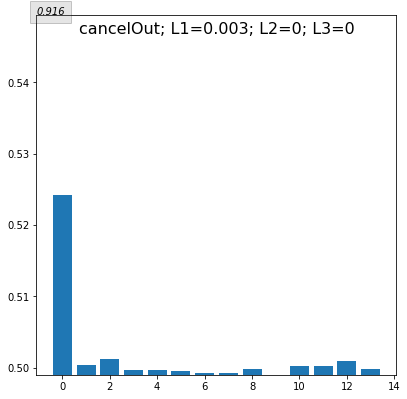

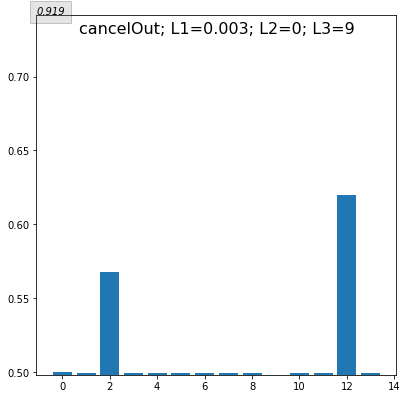

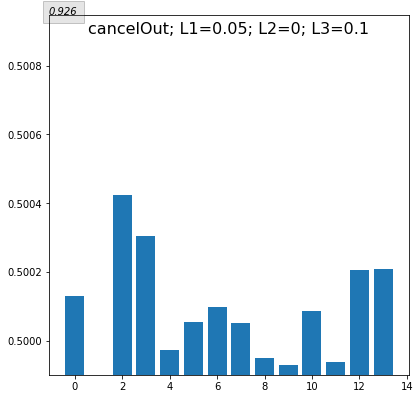

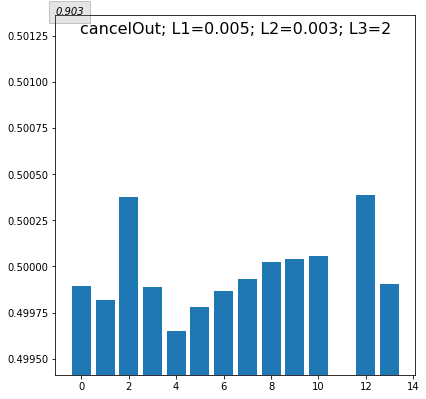

In [ ]:
param1 = [0.003,0.003,0.05,0.005]
param2 = [0,0,0,0.003]
param3 = [0,9, 0.1, 2]
for i in range(len(param1)):
  paramTuned = chooseParam("synth")
  paramTuned['l1_cancelOut'] = param1[i]
  paramTuned['l2_cancelOut'] = param2[i]
  paramTuned['l3_cancelOut'] = param3[i]
  key = "cancelOut"
  bcr = testWithtoutReduce(key, X_train_synth, y_train_synth, X_test_synth, y_test_synth, paramTuned, 100)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

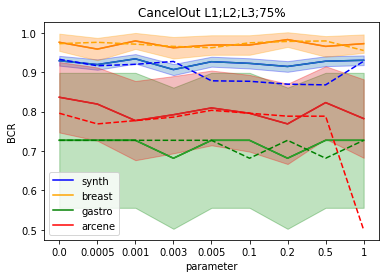

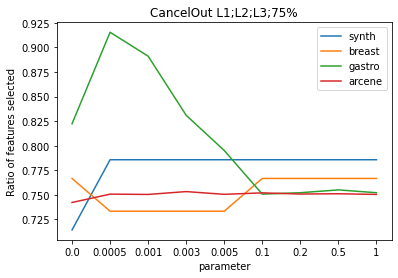

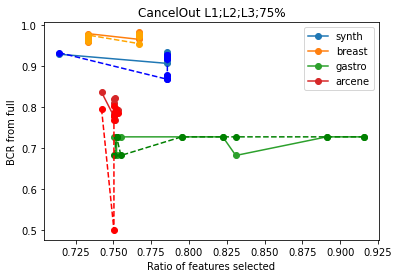

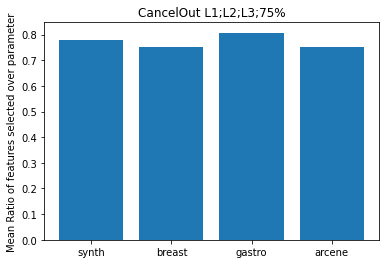

In [ ]:
key = "cancelOut"
param = "l1_cancelOut"
param2 = "l2_cancelOut"
param3 = "l3_cancelOut"

list_param = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
list_param2 = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
list_param3 = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
cancel_full_synth, cancel_reduced_synth, cancel_selFeatures_synth, cancel_stab_synth2 = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_gastro, cancel_reduced_gastro, cancel_selFeatures_gastro, cancel_stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_arcene, cancel_reduced_arcene, cancel_selFeatures_arcene, cancel_stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_breast, cancel_reduced_breast, cancel_selFeatures_breast, cancel_stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

clear_output(wait=True)
plotParamsCancel("CancelOut L1;L2;L3;75%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

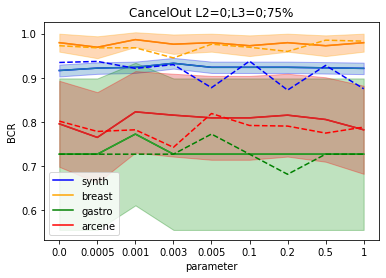

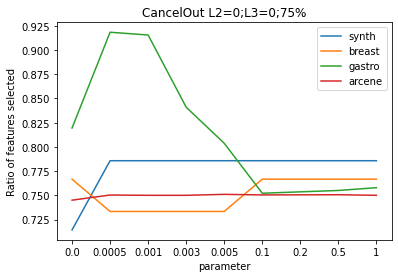

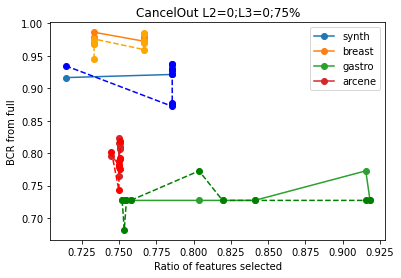

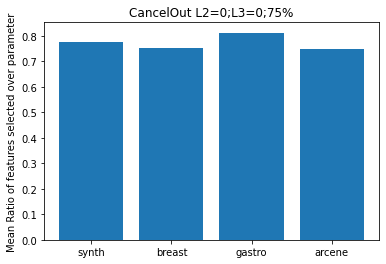

In [ ]:
key = "cancelOut"
param = "l1_cancelOut"
param2 = "l2_cancelOut"
param3 = "l3_cancelOut"

list_param =[0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
list_param2 = [0 for i in list_param] 
list_param3 = [0 for i in list_param] 
cancel_full_synth, cancel_reduced_synth, cancel_selFeatures_synth, cancel_stab_synth2 = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_gastro, cancel_reduced_gastro, cancel_selFeatures_gastro, cancel_stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_arcene, cancel_reduced_arcene, cancel_selFeatures_arcene, cancel_stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_breast, cancel_reduced_breast, cancel_selFeatures_breast, cancel_stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

clear_output(wait=True)
plotParamsCancel("CancelOut L2=0;L3=0;75%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

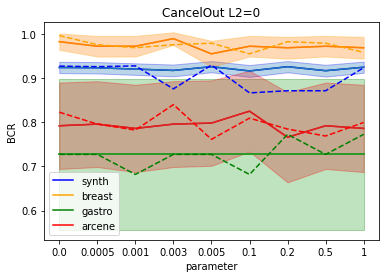

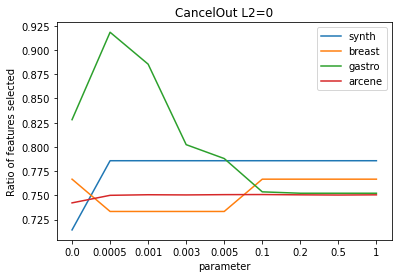

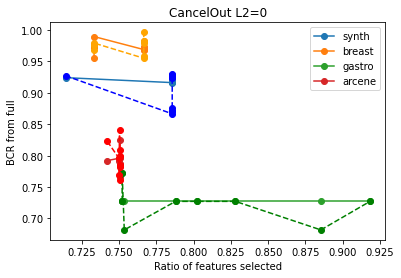

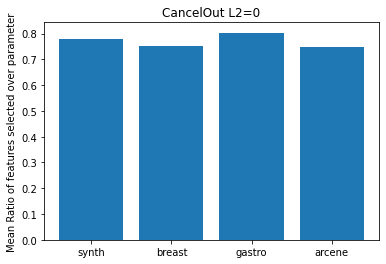

In [ ]:
key = "cancelOut"
param = "l1_cancelOut"
param2 = "l2_cancelOut"
param3 = "l3_cancelOut"

list_param =[0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
list_param2 = [0 for i in list_param] 
list_param3 = [0.000,0.0005, 0.001,0.1,0.2,0.5,1,5,10]
cancel_full_synth, cancel_reduced_synth, cancel_selFeatures_synth, cancel_stab_synth = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_gastro, cancel_reduced_gastro, cancel_selFeatures_gastro, cancel_stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_arcene, cancel_reduced_arcene, cancel_selFeatures_arcene, cancel_stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)

cancel_full_breast, cancel_reduced_breast, cancel_selFeatures_breast, cancel_stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key, 75, 100, param2, list_param2, param3, list_param3)
clear_output(wait=True)
plotParamsCancel("CancelOut L2=0")

Regularized

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

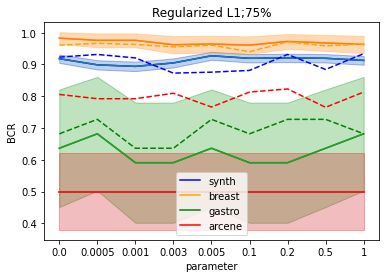

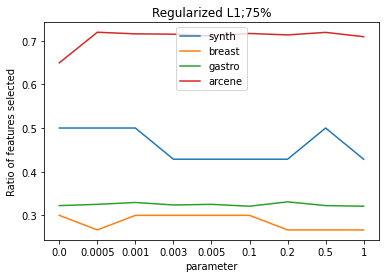

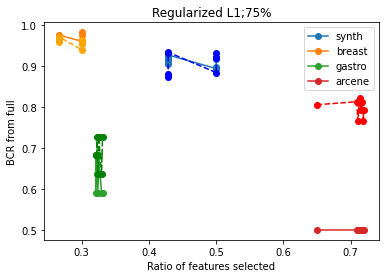

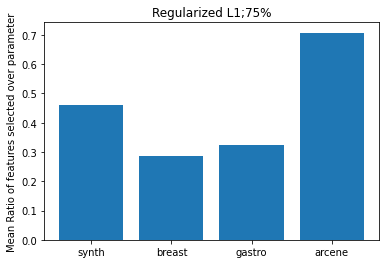

In [ ]:
key = "regularized"
param = "l1_regularized"
list_param = [0.000,0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]
full_synth, reduced_synth, selFeatures_synth, stab_synth = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 75, 100)

full_gastro, reduced_gastro, selFeatures_gastro, stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key,75,100)

full_breast, reduced_breast, selFeatures_breast, stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key,75,100)

clear_output(wait=True)
plotsParams("Regularized L1;75%")

NeuralFS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

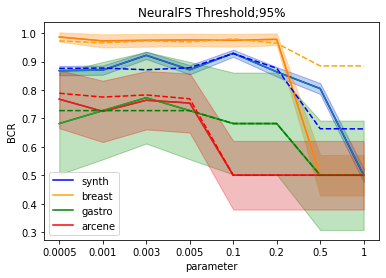

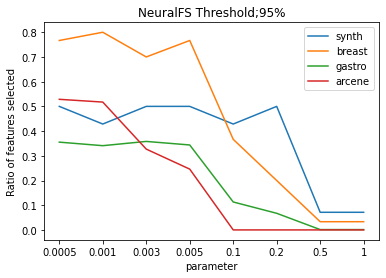

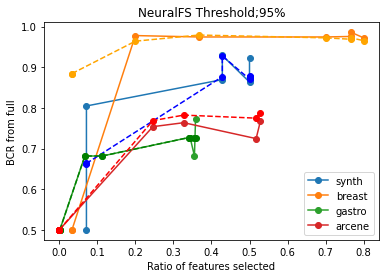

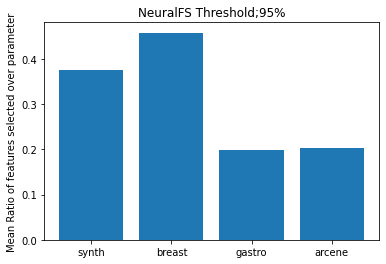

In [35]:
key = "neuralFS"
param = "threshold_neuralfs"
list_param = [0.0005, 0.001,0.003,0.005,0.1,0.2,0.5,1]

full_synth, reduced_synth, selFeatures_synth, stab_synth = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 95, 100)

full_gastro, reduced_gastro, selFeatures_gastro, stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key,95,100)

full_arcene, reduced_arcene, selFeatures_arcene, stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key,95,100)

full_breast, reduced_breast, selFeatures_breast, stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key,95,100)

clear_output(wait=True)
plotsParams("NeuralFS Threshold;95%")

LassoNet

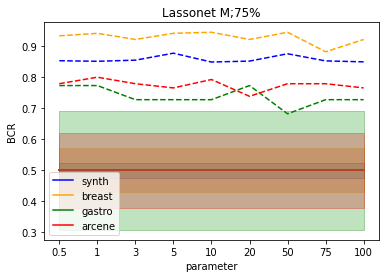

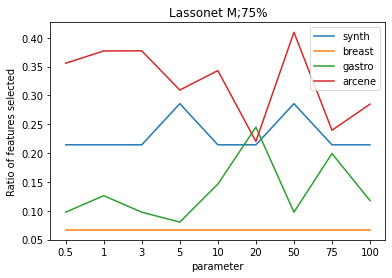

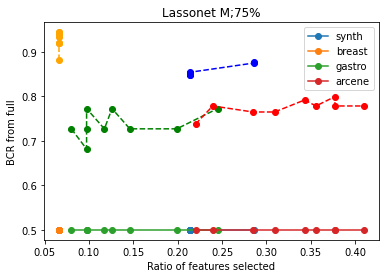

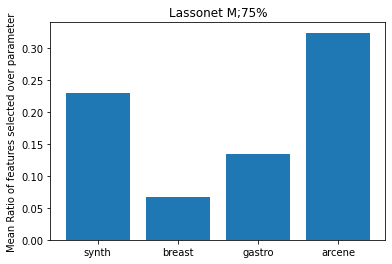

In [ ]:
key = "lassonet"
param = "lassonet_m"
list_param = [0.5,1,3,5,10,20,50,75,100]

full_synth, reduced_synth, selFeatures_synth, stab_synth = \
         testAllParam3(X_train_synth,y_train_synth, X_test_synth, y_test_synth, X_train_synth_not_scaled, param, chooseParam("synth"), list_param, key, 75, 100)

full_gastro, reduced_gastro, selFeatures_gastro, stab_gastro = \
         testAllParam3(X_train_gastro,y_train_gastro, X_test_gastro, y_test_gastro, X_train_gastro_not_scaled, param, chooseParam("gastro"), list_param, key,75,100)

full_arcene, reduced_arcene, selFeatures_arcene, stab_arcene = \
         testAllParam3(X_train_arcene,y_train_arcene, X_test_arcene, y_test_arcene, X_train_arcene_not_scaled, param, chooseParam("arcene"), list_param, key,75,100)

full_breast, reduced_breast, selFeatures_breast, stab_breast = \
         testAllParam3(X_train_breast,y_train_breast, X_test_breast, y_test_breast, X_train_breast_not_scaled, param, chooseParam("breast"), list_param, key,75,100)

clear_output(wait=True)
plotsParams("Lassonet M;75%")

###Features relevance

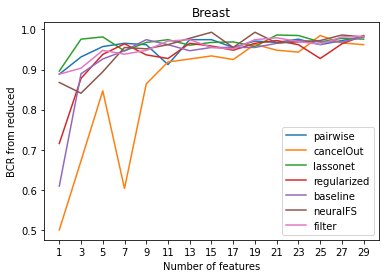

In [ ]:
import copy
listBCR = []
models = ["pairwise","cancelOut", "lassonet","regularized","baseline", "neuralFS","filter"]
for i in range(1,X_train_breast.shape[1],2):
  res = testModels(X_train_breast, y_train_breast, models, chooseParam("breast"), 100, X_test_breast, y_test_breast, percent=False,nFeat=i, showFeat=False, cols=False)
  reduced = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
  listBCR.append(copy.deepcopy(reduced))

clear_output(wait=True)
plt.title("Breast")
plt.plot([str(i) for i in range(1,X_train_breast.shape[1],2)], listBCR)
plt.ylabel('BCR from reduced')
plt.xlabel('Number of features')
plt.legend(models)

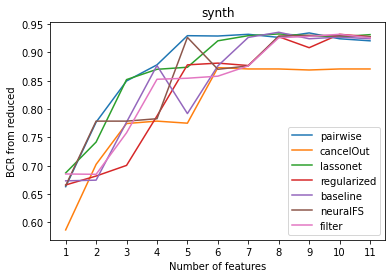

In [ ]:
import copy
listBCR = []
models =["pairwise","cancelOut", "lassonet","regularized","baseline", "neuralFS","filter"]
for i in range(1,12):
  res = testModels(X_train_synth, y_train_synth, models, chooseParam("synth"), 100, X_test_synth, y_test_synth, percent=False,nFeat=i, showFeat=False, cols=False)
  reduced = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
  listBCR.append(copy.deepcopy(reduced))

clear_output(wait=True)
plt.title("synth")
plt.plot([str(i) for i in range(1,12)], listBCR)
plt.ylabel('BCR from reduced')
plt.xlabel('Number of features')
plt.legend(models)

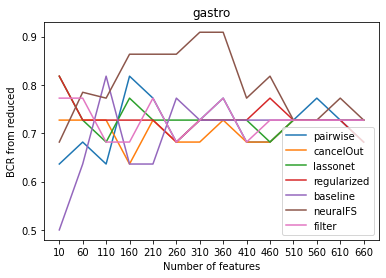

In [ ]:
import copy
listBCR = []
models =["pairwise","cancelOut", "lassonet","regularized","baseline", "neuralFS","filter"]
for i in range(10,X_train_gastro.shape[1],50):
  res = testModels(X_train_gastro, y_train_gastro, models, chooseParam("gastro"), 100, X_test_gastro, y_test_gastro, percent=False,nFeat=i, showFeat=False, cols=False)
  reduced = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
  listBCR.append(copy.deepcopy(reduced))

clear_output(wait=True)
plt.title("gastro")
plt.plot([str(i) for i in range(10,X_train_gastro.shape[1],50)], listBCR)
plt.ylabel('BCR from reduced')
plt.xlabel('Number of features')
plt.legend(models)

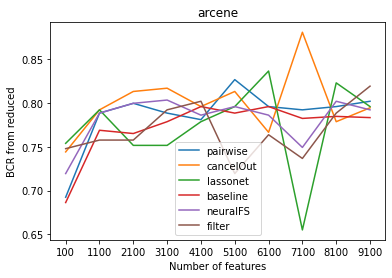

In [ ]:

listBCR = []
models =["pairwise","cancelOut", "lassonet","baseline", "neuralFS","filter"]
for i in range(100,X_train_arcene.shape[1],1000):
  res = testModels(X_train_arcene, y_train_arcene, models, chooseParam("arcene"), 100, X_test_arcene, y_test_arcene, percent=False,nFeat=i, showFeat=False, cols=False)
  reduced = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
  listBCR.append(copy.deepcopy(reduced))

clear_output(wait=True)
plt.title("arcene")
plt.plot([str(i) for i in range(100,X_train_arcene.shape[1],1000)], listBCR)
plt.ylabel('BCR from reduced')
plt.xlabel('Number of features')
plt.legend(models)

### BCR/Stability tradeoff of models

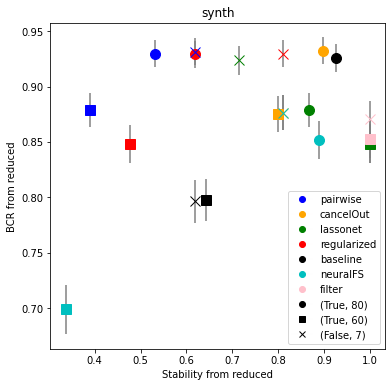

In [ ]:
import copy
listBCR = []
listStab = []
models = ["pairwise","cancelOut", "lassonet","regularized","baseline", "neuralFS","filter"]
mid = int(X_train_synth.shape[1]/2)
list_run = [(True, 80), (True,60), (False,mid)]
for i in list_run:
  res = testModels(X_train_synth, y_train_synth, models, chooseParam("synth"), 100, X_test_synth, y_test_synth, percent=i[0],nFeat=i[1], showFeat=False, cols=False)
  reduced = []
  stab = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
    stability = crossStab(key, 3, X_train_synth, y_train_synth, X_test_synth, y_test_synth, mapModel, chooseParam("synth"), percent=i[0],nFeat=i[1],epc=100,bs=32,verb=0)
    stab.append(stability)
  listBCR.append(copy.deepcopy(reduced))
  listStab.append(copy.deepcopy(stab))

clear_output(wait=True)
plotStabBcr("synth","synth")

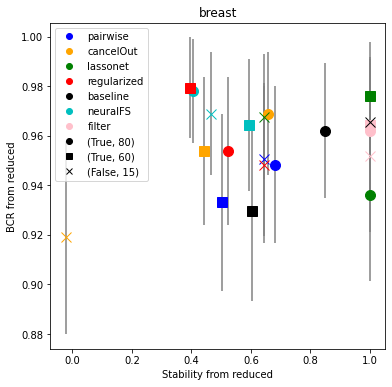

In [ ]:
import copy
listBCR = []
listStab = []
models = ["pairwise","cancelOut", "lassonet","regularized","baseline", "neuralFS","filter"]
mid = int(X_train_breast.shape[1]/2)
list_run = [(True, 80), (True,60), (False,mid)]
for i in list_run:
  res = testModels(X_train_breast, y_train_breast, models, chooseParam("breast"), 100, X_test_breast, y_test_breast, percent=i[0],nFeat=i[1], showFeat=False, cols=False)
  reduced = []
  stab = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
    stability = crossStab(key, 3, X_train_breast, y_train_breast, X_test_breast, y_test_breast, mapModel, chooseParam("synth"), percent=i[0],nFeat=i[1],epc=100,bs=32,verb=0)
    stab.append(stability)
  listBCR.append(copy.deepcopy(reduced))
  listStab.append(copy.deepcopy(stab))

clear_output(wait=True)
plotStabBcr("breast","breast")

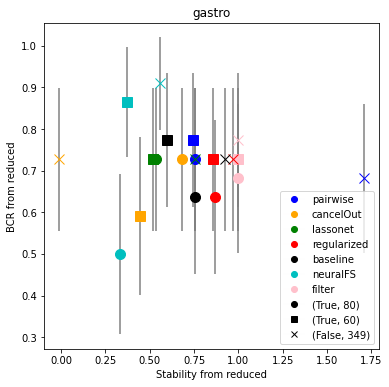

In [ ]:
import copy
listBCR = []
listStab = []
models =  ["pairwise","cancelOut", "lassonet","regularized","baseline", "neuralFS","filter"]
mid = int(X_train_gastro.shape[1]/2)
list_run = [(True, 80), (True,60), (False,mid)]
for i in list_run:
  res = testModels(X_train_gastro, y_train_gastro, models, chooseParam("gastro"), 100, X_test_gastro, y_test_gastro, percent=i[0],nFeat=i[1], showFeat=False, cols=False)
  reduced = []
  stab = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
    stability = crossStab(key, 3, X_train_gastro, y_train_gastro, X_test_gastro, y_test_gastro, mapModel, chooseParam("synth"), percent=i[0],nFeat=i[1],epc=100,bs=32,verb=0)
    stab.append(stability)
  listBCR.append(copy.deepcopy(reduced))
  listStab.append(copy.deepcopy(stab))

clear_output(wait=True)
plotStabBcr("gastro","gastro")

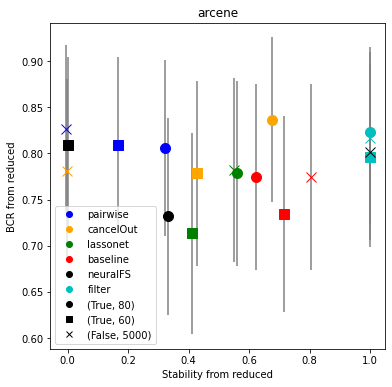

In [ ]:
import copy
listBCR = []
listStab = []
models =  ["pairwise","cancelOut", "lassonet","baseline", "neuralFS","filter"]
mid = int(X_train_arcene.shape[1]/2)
list_run = [(True, 80), (True,60), (False,mid)]
for i in list_run:
  res = testModels(X_train_arcene, y_train_arcene, models, chooseParam("arcene"), 100, X_test_arcene, y_test_arcene, percent=i[0],nFeat=i[1], showFeat=False, cols=False)
  reduced = []
  stab = []
  for key in models:
    reduced.append(res["test_bcr_baseline_reduced_from_"+key])
    stability = crossStab(key, 3, X_train_arcene, y_train_arcene, X_test_arcene, y_test_arcene, mapModel, chooseParam("arcene"), percent=i[0],nFeat=i[1],epc=100,bs=32,verb=0)
    stab.append(stability)
  listBCR.append(copy.deepcopy(reduced))
  listStab.append(copy.deepcopy(stab))

clear_output(wait=True)
plotStabBcr("arcene","arcene")